In [195]:
import tensorflow as tf
import pathlib, glob, re
%pylab inline
tf.enable_eager_execution()

Populating the interactive namespace from numpy and matplotlib


In [196]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [197]:
BATCH_SIZE = 32

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize_images(image, [50, 50])
  image /= tf.constant(255.0)
  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def classname_from_path(path):
    return re.search(r'.*/(?P<dir>[a-z _]*)/[0-9]*\.jpg', path).group('dir')

def classname_from_class_path(path):
    return re.search(r'.*/(?P<dir>[a-z _]*)/', path).group('dir')

def label_to_number(onehot):
    return np.nonzero(onehot.numpy())[0][0]

In [246]:
train_paths = []
test_paths = []
all_image_classnames = []
all_classes_paths = glob.glob('/home/datasets-local/places365/train/data_256/[w]/*/')

for class_path in all_classes_paths:
    classname = classname_from_class_path(class_path)
    all_image_classnames.append(classname)
    
    class_image_paths = glob.glob(class_path + '/*.jpg')
    images_in_class = len(class_image_paths)
    print("Class: %s, has %d images" % (classname, images_in_class))
    
    train_paths += class_image_paths[:images_in_class*3//4]
    test_paths += class_image_paths[images_in_class*3//4:]

Class: wind_farm, has 5000 images
Class: water_tower, has 5000 images
Class: waterfall, has 5000 images
Class: wheat_field, has 5000 images
Class: waiting_room, has 5000 images
Class: water_park, has 5000 images
Class: windmill, has 5000 images
Class: wet_bar, has 5000 images
Class: wave, has 5000 images
Class: watering_hole, has 5000 images


In [247]:
random.shuffle(train_paths)

In [248]:
CLASSES = len(set(all_image_classnames))
classname_dict = dict()

def get_labels(image_paths):
    labels = []
    for image_path in image_paths:
        classname = classname_from_path(image_path)
        if classname not in classname_dict:
            classname_dict[classname] = len(classname_dict)
        labels.append(tf.one_hot(classname_dict[classname], CLASSES))
    return labels

train_labels = get_labels(train_paths)
test_labels = get_labels(test_paths)

In [249]:
number_to_classname = ['' for _ in range(CLASSES)]
for k in classname_dict.keys():
    number_to_classname[classname_dict[k]] = k

Construct $all\_image\_labels$ and $label\_to\_classname$

In [250]:
print(train_labels[:5])
print(test_labels[:5])

[<tf.Tensor: id=2450661, shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=2450666, shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=2450671, shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=2450676, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=2450681, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)>]
[<tf.Tensor: id=2638161, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=2638166, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=2638171, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id

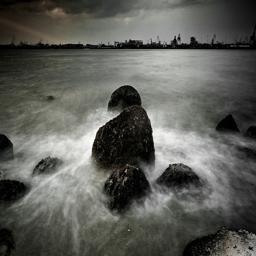

wave


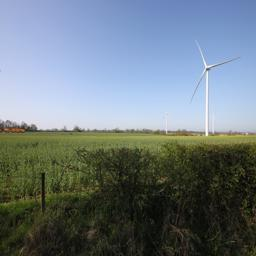

wind_farm


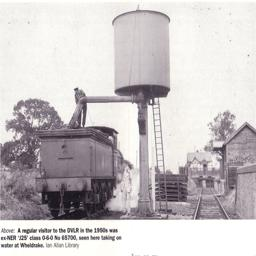

water_tower


In [251]:
from IPython.display import Image, display

for _ in range(3):
    x = np.random.randint(1, high=len(train_paths))
    display(Image(train_paths[x]))
    print(classname_from_path(train_paths[x]))

In [258]:
def load_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess_from_path_label)
    ds = ds.shuffle(buffer_size=64)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [259]:
train_ds = load_dataset(train_paths, train_labels)

In [260]:
test_ds = load_dataset(test_paths, test_labels)

# Model

In [261]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(50, 50, 3)),
  tf.keras.layers.Dense(250, activation=tf.nn.tanh),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(500, activation=tf.nn.tanh),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(CLASSES, activation=tf.nn.softmax)
])
model.compile(optimizer=tf.train.RMSPropOptimizer(learning_rate=0.001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 7500)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 250)               1875250   
_________________________________________________________________
dropout_36 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 500)               125500    
_________________________________________________________________
dropout_37 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 10)                5010      
Total params: 2,005,760
Trainable params: 2,005,760
Non-trainable params: 0
_________________________________________________________________


In [276]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

In [281]:
history = LossHistory()
model.fit(train_ds, epochs=7, steps_per_epoch=len(train_paths)//BATCH_SIZE, callbacks=[history])

Epoch 1/7
1171/1171 [==============================] - 35s 30ms/step - loss: 2.0021 - acc: 0.2622
Epoch 2/7
1171/1171 [==============================] - 35s 30ms/step - loss: 1.9798 - acc: 0.2664
Epoch 3/7
1171/1171 [==============================] - 35s 30ms/step - loss: 1.9684 - acc: 0.2738
Epoch 4/7
1171/1171 [==============================] - 35s 30ms/step - loss: 1.9484 - acc: 0.2848
Epoch 5/7
1171/1171 [==============================] - 35s 30ms/step - loss: 1.9336 - acc: 0.2928
Epoch 6/7
1171/1171 [==============================] - 35s 30ms/step - loss: 1.9355 - acc: 0.2932
Epoch 7/7
1171/1171 [==============================] - 35s 30ms/step - loss: 1.9174 - acc: 0.3022


In [282]:
model.fit(train_ds, epochs=3, steps_per_epoch=len(train_paths)//BATCH_SIZE, callbacks=[history])

Epoch 1/3
1171/1171 [==============================] - 35s 30ms/step - loss: 1.9211 - acc: 0.3000
Epoch 2/3
1171/1171 [==============================] - 35s 30ms/step - loss: 1.9117 - acc: 0.3041
Epoch 3/3
1171/1171 [==============================] - 35s 30ms/step - loss: 1.9104 - acc: 0.3071


# Testing and predicting

In [286]:
model.evaluate(test_ds, steps=len(test_paths)//BATCH_SIZE)

390/390 [==============================] - 13s 32ms/step - loss: 1.7564 - acc: 0.3372


[1.7563564309707054, 0.33717948]

In [287]:
model.evaluate(train_ds, steps=len(train_paths)//BATCH_SIZE)

1171/1171 [==============================] - 35s 30ms/step - loss: 1.7305 - acc: 0.3462


[1.7305453419176358, 0.3461518]

In [288]:
data, target = next(iter(test_ds))
image = data[0]
label = target[0]

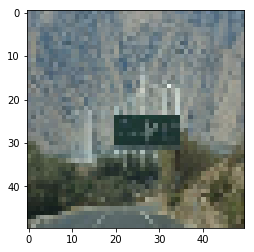

In [289]:
plt.imshow(image)

In [290]:
number_to_classname[label_to_number(label)]

'wind_farm'

In [299]:
it = iter(test_ds)
cfm = np.zeros((10, 10))
for i in range(len(test_paths)//BATCH_SIZE):
    if i%50 == 0:
        print(i)
    data, target = next(it)
    pred = model.predict(data.numpy())
    for i in range(res.shape[0]):
        cfm[label_to_number(target[i])][np.argmax(pred[i])] += 1

0
50
100
150
200
250
300
350


In [302]:
cfm

array([[  0.,  72.,   4.,  20., 147.,   1.,  57., 102., 757.,  90.],
       [  0., 692.,   3.,  26.,  23.,   3.,  18.,  69., 305., 111.],
       [  0.,  36., 252.,  34., 282.,   1.,  21.,  45., 286., 293.],
       [  0., 218.,  16., 199.,  97.,  16.,   6., 192., 199., 287.],
       [  0.,  24.,  61.,  20., 534.,   0.,  44.,  51., 407., 109.],
       [  0., 123.,   2.,  78.,  14.,  10.,   1., 857.,  35., 130.],
       [  0., 121.,   6.,   6., 129.,   0.,  64.,  75., 814.,  35.],
       [  0., 139.,   5.,  66.,  21.,   8.,  11., 732., 117., 151.],
       [  0., 143.,   2.,   4.,  84.,   0.,  56., 102., 783.,  76.],
       [  0.,  49.,  30.,  34.,  54.,   1.,  20.,  56.,  63., 943.]])

In [264]:
number_to_classname

['water_tower',
 'wheat_field',
 'water_park',
 'watering_hole',
 'wave',
 'wet_bar',
 'wind_farm',
 'waiting_room',
 'windmill',
 'waterfall']

In [305]:
np.diag(cfm).sum()/cfm.sum()

0.3372596153846154